In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors

In [3]:
from read_wandb import wandb_results
api = wandb_results("NLP2024_PROJECT_318403599", wandb_username="technion11")

BASE_METRIC = "accuracy_per_mean_user_and_bot"


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=False, metric=BASE_METRIC, epoch="best"):
    df = api.get_sweeps_results(sweeps, metric=metric)

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
    print(HPT_cols)
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]

    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    grouped = df.groupby([c for c in HPT_cols if c != "config_seed"])
    mean_df = grouped[numeric_cols].mean()
    std_df = grouped[numeric_cols].std()
    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)

    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

In [5]:
!mkdir sweeps_csvs

In [6]:
sweep_results = result_metric(["urzli4bq"], "LLMs", drop_HPT=False, epoch='best')
sweep_results


Total number of sweeps: 1
Download sweep_id='urzli4bq' data...


100%|██████████| 6/6 [00:00<00:00, 1845.95it/s]


['config_seed', 'config_basic_nature']


,mean,std,values,epoch,CI
LLMs,,,,,
1,0.824109,0.000824,"[0.8235261542617325, 0.8246914960348858]",2,"(0.8235261542617325, 0.8246914960348858)"
2,0.824287,0.000124,"[0.8241992883504465, 0.8243750005391196]",7,"(0.8241992883504465, 0.8243750005391196)"
3,0.825888,0.001753,"[0.8246487023958509, 0.8271275720594413]",7,"(0.8246487023958509, 0.8271275720594413)"


# Result for a specific epoch

In [7]:
# sweep_results = result_metric(["ralq8ijs"], "LLMs", drop_HPT=True, epoch='best')
# sweep_results

In [11]:
cd sweeps_csvs

[Errno 2] No such file or directory: 'sweeps_csvs'
/content/sweeps_csvs


In [12]:
df = pd.read_csv("ralq8ijs_19.csv")

In [13]:
temp = pd.read_csv("urzli4bq_6.csv")

In [14]:
df = pd.concat([df, temp])

In [41]:
df = df[df['config_online_simulation_factor'] == 4]
df.drop(columns=[col for col in df.columns if 'ENV_Test_accuracy_per_mean_user_and_bot_epoch' in col and
                 int(col.split('epoch')[1]) > 10], inplace=True, axis=1)

In [46]:
def result_metric(df, group_name, drop_list=[], drop_HPT=False, metric=BASE_METRIC, epoch="best"):
    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
    print(HPT_cols)
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]

    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    grouped = df.groupby([c for c in HPT_cols if c != "config_seed"])
    mean_df = grouped[numeric_cols].mean()
    std_df = grouped[numeric_cols].std()
    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)
    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))
    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound

In [43]:
results_df = result_metric(df.drop(columns=['config_total_epochs']), 'config_basic_nature')

['config_seed', 'config_basic_nature']
config_basic_nature
0    ENV_Test_accuracy_per_mean_user_and_bot_epoch7
1    ENV_Test_accuracy_per_mean_user_and_bot_epoch2
2    ENV_Test_accuracy_per_mean_user_and_bot_epoch6
3    ENV_Test_accuracy_per_mean_user_and_bot_epoch6
dtype: object


In [44]:
summary_df = results_df[['mean', 'std', 'CI']]

In [48]:
max_idx =summary_df.dropna().groupby(level=0)['mean'].idxmax()
max_rows_df = summary_df.loc[max_idx]
max_rows_df = max_rows_df.round(3)

In [50]:
max_rows_df['CI'] = max_rows_df['CI'].apply(lambda x: (round(x[0], 3), round(x[1], 3)))

In [51]:
labels_dict= {0: 'Baseline Model',
    1: 'Equal probabilities for each category',
    2: 'Higher probability for cleanliness',
    3: 'Higher probability for location'}

In [55]:
max_rows_df = max_rows_df.reset_index()
max_rows_df['DM'] = max_rows_df['config_basic_nature'].apply(lambda x: labels_dict[x])

In [56]:
max_rows_df[['DM', 'mean', 'std','CI']]

,DM,mean,std,CI
0,Baseline Model,0.836,0.003,"(0.834, 0.839)"
1,Equal probabilities for each category,0.823,0.002,"(0.822, 0.825)"
2,Higher probability for cleanliness,0.823,0.003,"(0.82, 0.824)"
3,Higher probability for location,0.826,0.003,"(0.824, 0.829)"


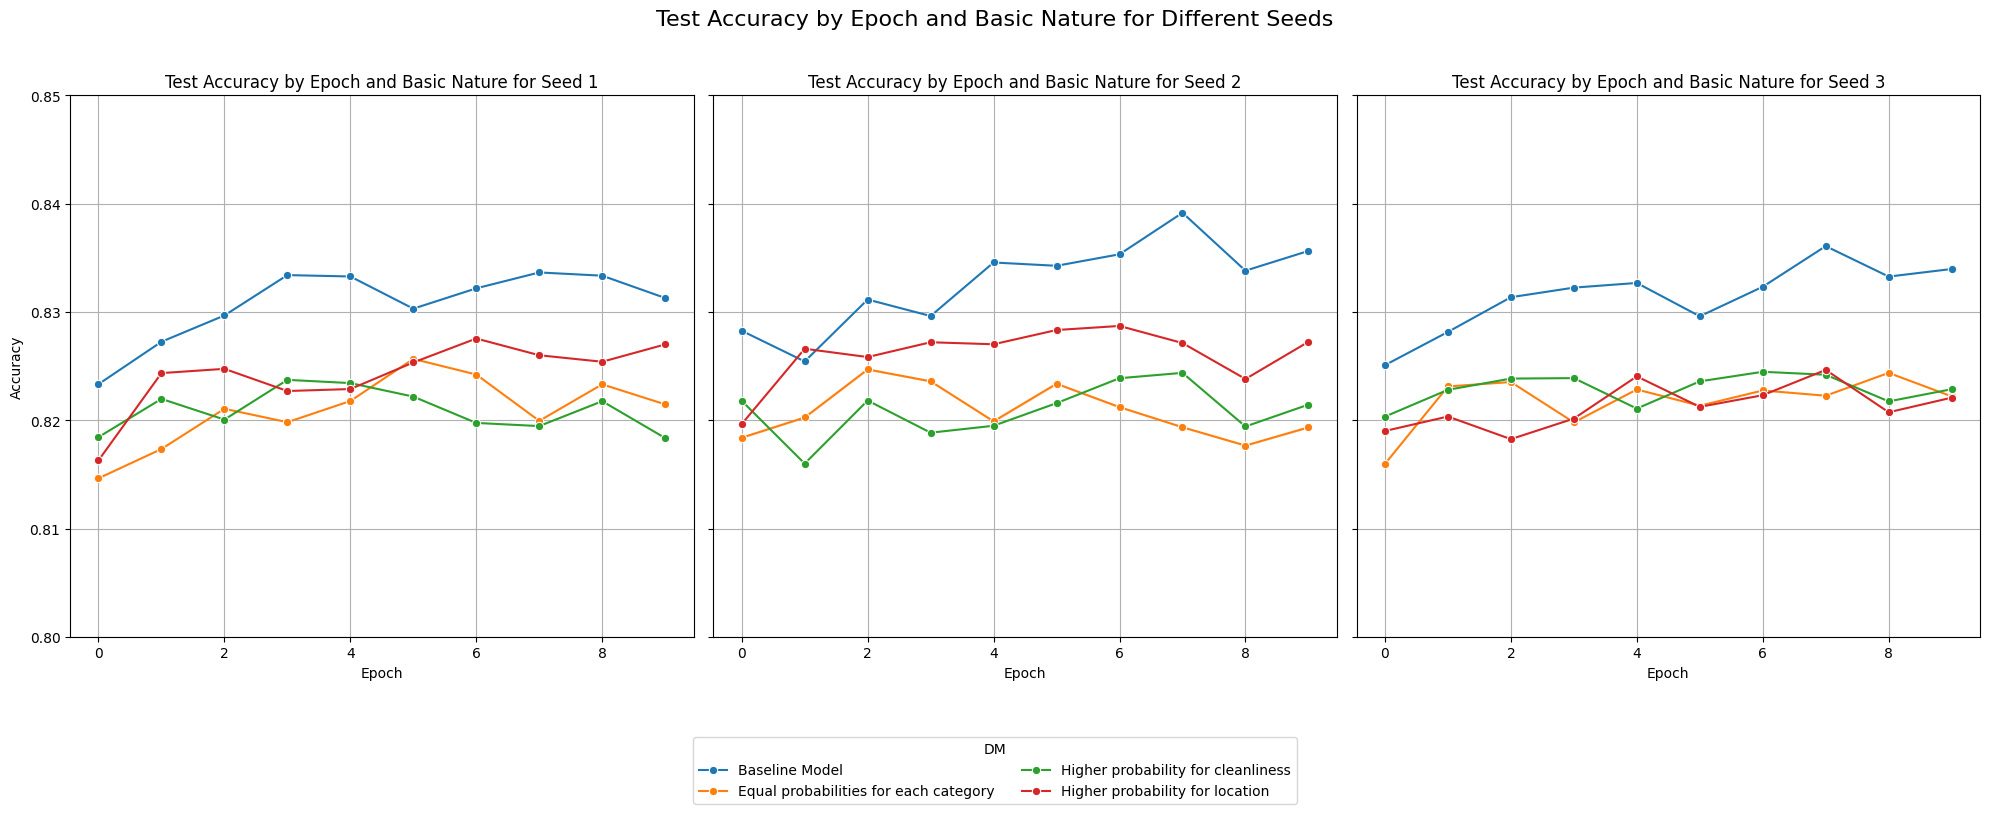

In [70]:
import seaborn as sns

epoch_columns = [col for col in df.columns if 'ENV_Test_accuracy_per_mean_user_and_bot_epoch' in col]
seeds = sorted(df['config_seed'].unique())
num_seeds = len(seeds)

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharex=True, sharey=True)
axes = axes.flatten()

for i, (seed, ax) in enumerate(zip(seeds, axes)):
    seed_df = df[df['config_seed'] == seed]
    seed_df = seed_df[seed_df['config_online_simulation_factor'] == 4]
    seed_df = seed_df[epoch_columns + ['config_basic_nature']]
    seed_df = seed_df.reindex(sorted(seed_df.columns), axis=1)

    # Melt the DataFrame to have epochs as rows
    melted_df = seed_df.melt(id_vars='config_basic_nature',
                             var_name='epoch',
                             value_name='accuracy')

    # Extract epoch number from the column names
    melted_df['epoch'] = melted_df['epoch'].str.extract('(\d+)').astype(int)
    melted_df = melted_df[melted_df['epoch'] < 10]
    melted_df.rename({'config_basic_nature': 'DM'}, axis=1, inplace=True)
    melted_df['DM'] = melted_df['DM'].apply(lambda x: labels_dict[x])
    melted_df.sort_values(by=['DM'], inplace=True)

    # Plot the results using seaborn
    sns.lineplot(data=melted_df, x='epoch', y='accuracy', hue='DM', marker='o', ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Test Accuracy by Epoch and Basic Nature for Seed {seed}')
    ax.grid(True)
    ax.get_legend().remove()
    ax.set_ylim([0.8, 0.85])

# Create one legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='DM', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Adjust layout and show the plot
plt.suptitle('Test Accuracy by Epoch and Basic Nature for Different Seeds', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()